# Домашнее задание - линейная регрессия

Подготовил: Соколов Дмитрий Алексеевич

Ссылка LMS: https://lms.yandex.ru/profile/310061

In [ ]:
#!pip install pycountry-convert

In [46]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pycountry_convert as pc
import pycountry

from sklearn.base import RegressorMixin

from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

### Работа с признаками (8 баллов)

Скачайте датасет из материалов к уроку или по ссылке https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv 


Описание признаков:

* Agency — название страхового агентства
* Agency Type — тип страхового агентства
* Distribution Channel — канал продвижения страхового агентства
* Product Name — название страхового продукта
* Duration — длительность поездки (количество дней)
* Destination — направление поездки
* Net Sales — сумма продаж 
* Commission (in value) — комиссия страхового агентства
* Gender — пол застрахованного
* Age — возраст застрахованного

Ответ:
* Claim — потребовалась ли страховая выплата: «да» — 1, «нет» — 0

Обработайте пропущенные значения и примените написанные функции onehot_encode() и minmax_scale().

**Подсказка**: маску для категориальных признаков можно сделать фильтром cat_features_mask = (df.dtypes == "object").values

In [59]:
url = "https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv"
data = pd.read_csv(url)
data

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41
...,...,...,...,...,...,...,...,...,...,...,...
63321,JZI,Airlines,Online,Basic Plan,No,111,JAPAN,35.0,12.25,M,31
63322,JZI,Airlines,Online,Basic Plan,No,58,CHINA,40.0,14.00,F,40
63323,JZI,Airlines,Online,Basic Plan,No,2,MALAYSIA,18.0,6.30,M,57
63324,JZI,Airlines,Online,Basic Plan,No,3,VIET NAM,18.0,6.30,M,63


In [60]:
# plt.figure(figsize = (50,50))
# sns.heatmap(pd.get_dummies(data).corr(), annot=True, fmt=".2f")
# plt.grid()
# plt.show()

In [61]:
data = data.drop(["Gender"], axis=1)

Подробный анализ и подготовка датасета часто помогают улучшить качество модели. Ниже представлено несколько идей преобразований. Вы можете применить одно или несколько из этих преобразований (а можете не применять), чтобы помочь будущей модели. 

1. Посмотрите на количественные признаки. Возможно, в некоторых признаках есть выбросы - значения, которые сильно выбиваются. Такие значения полезно удалять. Советуем присмотреться к колонке Duration)

2. Можно заметить, что one hot encoding сильно раздувает количество столбцов. Радикальное решение - можно попробовать выбросить все категориальные признаки из датасета.

3. Если все-таки оставляете категориальные признаки, то подумайте, как уменьшить количество столбцов после one hot encoding. Признаки с большим количеством значений (Duration - 149! разных стран) можно удалить или попробовать сгруппировать некоторые значения.

4. Downsampling. Датасет достаточно большой, разница в классах огромная. Можно уменьшить число наблюдений с частым ответом.

In [71]:
data["Destination"] = data["Destination"].apply(lambda x:
                                                pc.convert_continent_code_to_continent_name(
                                                    pc.country_alpha2_to_continent_code(
                                                        pc.country_name_to_country_alpha2(
                                                            pycountry.countries.lookup((x.title())).name
                                                        )
                                                    )
                                                ))
data

LookupError: Could not find a record for 'turkey'

In [16]:
# Преобразуем таргеты в 1 и 0.
# Удаляем колонку `Destination` потому, что там 149 различных признаков и после применения OneHotEncoder количество фичей будет слишком много для обучения.
# Удаляем колонку `Gender`, так как там 75% данных это nan и восстановление их, даже при помощи методов машинного обучения, будет сулить неверному вкладу в исходное предсказание.
data["Claim"] = np.where(data["Claim"] == "Yes", 1, 0)

# Будем пользоваться ColumnTransformer для удобства обработки сразу нескольких признаков
# Для этого получим названия нужных колонок для преобразования
cat_features_mask = (data.dtypes == "object")
cat_features = data.columns[cat_features_mask]
num_features = data.columns[cat_features_mask == False].drop("Claim")

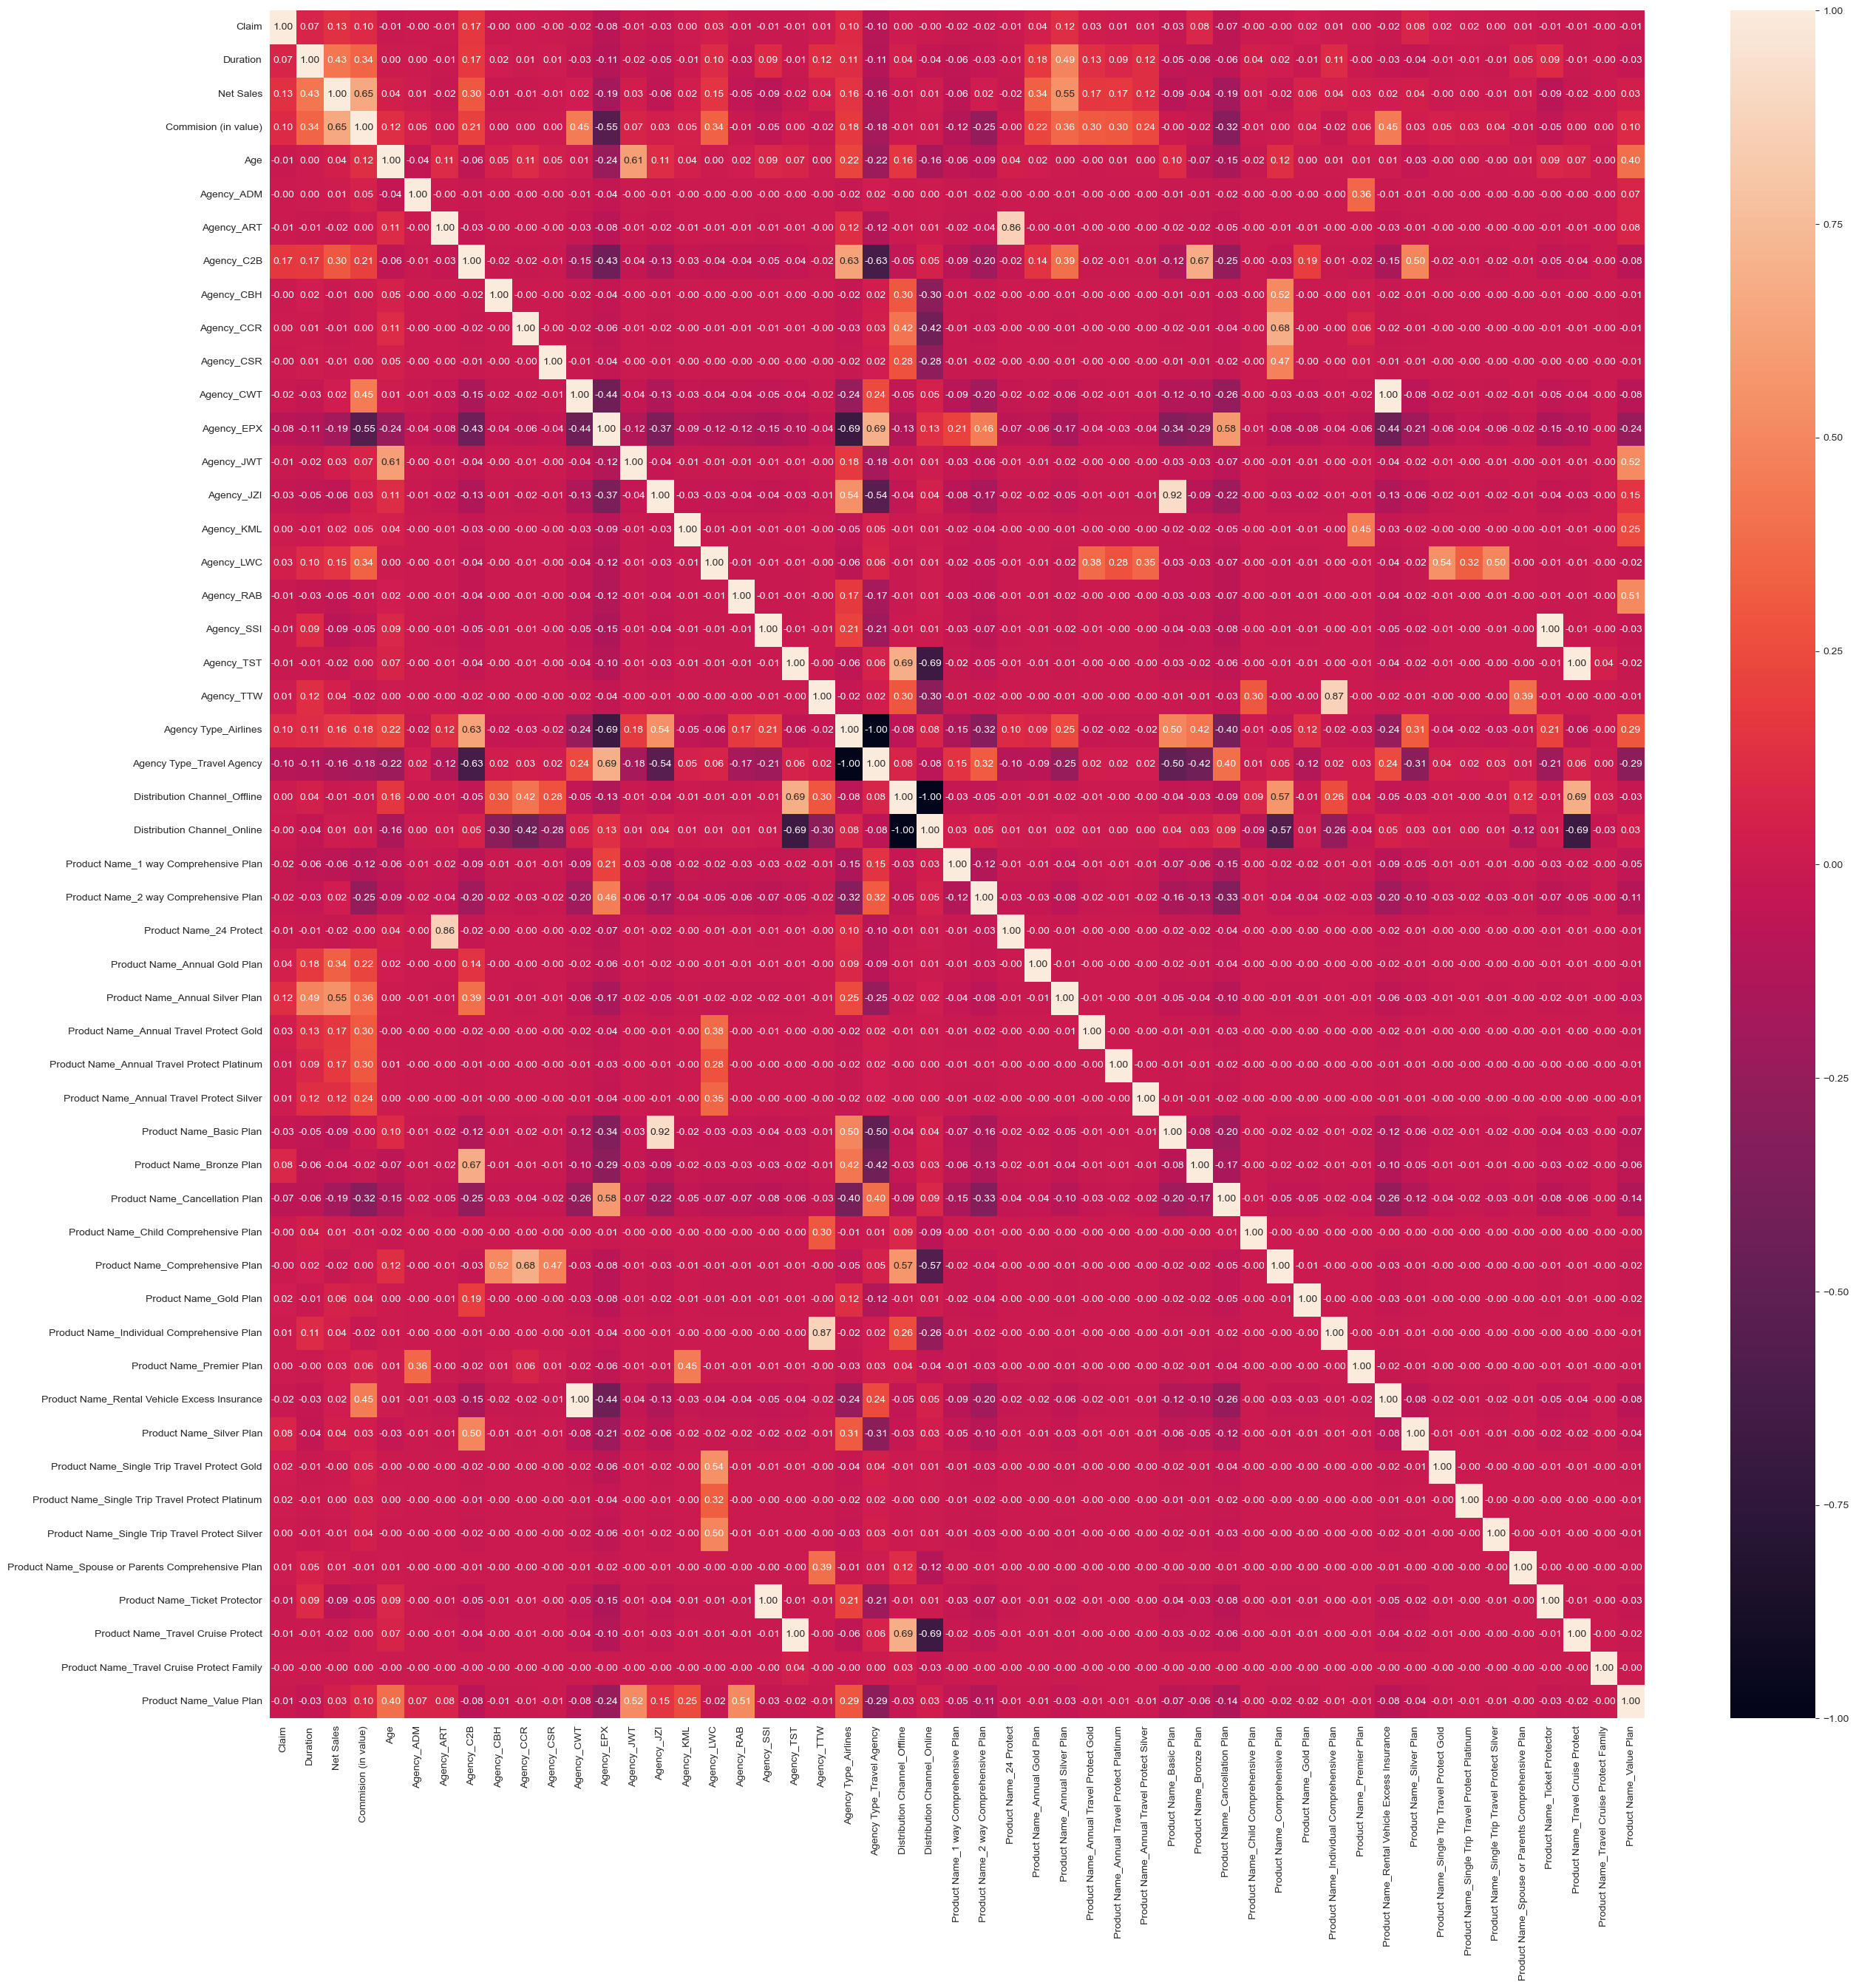

In [19]:
plt.figure(figsize=(30, 30))
sns.heatmap(pd.get_dummies(data).corr(), annot=True, fmt=".2f")
plt.grid()
plt.show()

In [21]:
# Создадим наш ColumnTransformer, и пока будем игнорировать всякие выбросы и некорректные данные, посмотрим какую метрику получим.
# Для остальных признаков, которые мы не учли (хотя таковых не должно остаться), будем их просто пропускать, и для преобразования задействуем все возможные потоки, ведь количество данных 60 тыс. строк, а преобразование ColumnTransformer довольно ресурсоемкий процесс
ct = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ("num", MinMaxScaler(), num_features)
], remainder="passthrough", n_jobs=-1).set_output(transform="pandas")

### Применение линейной регрессии (10 баллов)

Это задача классификации, но её можно решить с помощью линейной регрессии, если округлять предсказанный ответ до целого и выбирать ближайший по значению ответ из множества {0, 1}.

Вынесите признак 'Claim' в вектор ответов и разделите датасет на обучающую и тестовую выборку в соотношении 80 к 20. Зафиксируйте random_state.

**Подсказка:** быстро перевести Yes/No в 1/0 можно так - np.where(df['Claim'] == 'Yes', 1,0)

In [22]:
# Разделим данные тренировочную и тестовую часть
X_data, y_data = data.drop(["Claim"], axis=1), data["Claim"]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=239)

Найдите аналитическое решение для обучающей выборки: обычное и регуляризацией l2.

In [23]:
# Создадим свой регрессор для вычисления аналитического решения
class AnalyticRegressor(RegressorMixin):

    def __init__(self, *, alpha=0, p=2):
        self.w = None
        self.alpha = alpha
        self.p = p
        self.pred = None

    def fit(self, X=None, y=None):
        if X is None:
            return self
        if y is None:
            return self

        X = X.to_numpy()
        y = y.to_numpy()
        self.w = np.linalg.inv(X.T @ X + self.alpha ** self.p * np.eye(X.shape[1])) @ X.T @ y
        return self

    def predict(self, X=None):
        if X is None:
            return self.pred

        self.pred = np.round(X @ self.w)
        return self.pred

In [24]:
# Создадим контейнер для автоматизации работы с данными
pipe = Pipeline([
    ("preprocessing", ct),
    ("model", AnalyticRegressor())
])
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name'], dtype='object')),
                                                 ('num', MinMaxScaler(),
                                                  Index(['Duration', 'Net Sales', 'Commision (in value)', 'Age'], dtype='object'))])),
                ('model',
                 <__main__.AnalyticRegressor object at 0x00000117DB8966C0>)])

In [25]:
# посчитайте аналитическое решение

## Настройка контейнера
analytic_common = AnalyticRegressor(alpha=0)
pipe.set_params(model=analytic_common)

## Обучение и предсказание
try:
    pipe.fit(X_train, y_train)
    comon_y_pred = pipe.predict(X_test)
    comon_mse = mean_squared_error(y_test, comon_y_pred)
    print(comon_mse)
except Exception as e:
    print("LinAlgError: Singular matrix")

LinAlgError: Singular matrix


In [26]:
# посчитать аналитическое решение с регуляризацией

## Настройка контейнера
analytic_regular = AnalyticRegressor(alpha=10)
pipe.set_params(model=analytic_regular)

## Обучение и предсказание
pipe.fit(X_train, y_train)
regular_y_pred = pipe.predict(X_test)
regular_mse = mean_squared_error(y_test, regular_y_pred)
regular_mse

0.014842886467708826

Постройте модель LinearRegression, примените к тестовой выборке и посчитайте MSE (можно использовать библиотеку sklearn)

In [28]:
# обучите модель линейной регрессии LinearRegression на обучающей выборке, примените к тестовой

## Настройка контейнера
lr = LinearRegression()
pipe.set_params(model=lr)

## Обучение и предсказание
pipe.fit(X_train, y_train)
lr_y_pred = np.round(pipe.predict(X_test))

# отнормируем результат ввиду отсутствия регуляризации
# lr_y_pred = (lr_y_pred - lr_y_pred.min())/(lr_y_pred.max() - lr_y_pred.min())

In [29]:
np.unique(lr_y_pred)

array([0.])

In [30]:
np.unique(y_test)

array([0, 1])

In [31]:
# посчитайте MSE, предварительно округлив предсказанные ответы до целого
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_mse

0.014842886467708826

### Вывод (1 балла)

Напишите краткий вывод по заданию (достаточно пары предложений). Расскажите, какие способы предобработки данных вы выбрали и почему. Насколько хороша ваша модель?

Таким образом, при удалении пары столбцов (`Destination`, `Gender`) и минимальной обработке данных (`OneHotEncoder` и `MinMaxScaler`) получаем следующие результаты.

MSE для аналитического решения без регуляризации: не существует

MSE для аналитического решения с регуляризацией при $\lambda = 10$: `0.01484`

MSE при использовании линейной регрессии и нормировке: `0.01547`

Отсюда следует что использование аналитического решения с регуляризацией для данной задачи более предпочтительно.